In [488]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior
from bliss.datasets.galsim_galaxies import GalsimBlends


In [489]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:



In [560]:
def _add_noise_and_background(image: Tensor, background: Tensor) -> Tensor:
    image_with_background = image + background
    noise = image_with_background.sqrt() * torch.randn_like(image_with_background)
    return image_with_background + noise

def load_psf_from_file(psf_image_file: str, pixel_scale: float) -> galsim.GSObject:
    """Return normalized PSF galsim.GSObject from numpy psf_file."""
    assert Path(psf_image_file).suffix == ".npy"
    psf_image = np.load(psf_image_file)
    assert len(psf_image.shape) == 3 and psf_image.shape[0] == 1
    psf_image = galsim.Image(psf_image[0], scale=pixel_scale)
    return galsim.InterpolatedImage(psf_image).withFlux(1.0)

def _sample_n_sources(max_n_sources) -> int:
    return int(torch.randint(1, max_n_sources + 1, (1,)).int().item())

def _uniform(a, b, n_samples=1) -> Tensor:
    # uses pytorch to return a single float ~ U(a, b)
    return (a - b) * torch.rand(n_samples) + b

class CoaddUniformGalsimGalaxiesPrior(UniformGalsimGalaxiesPrior):
    def __init__(
        self,
        single_galaxy_prior: SingleGalsimGalaxyPrior,
        max_n_sources: int,
        max_shift: float,
        num_dithers: int,
    ):
        super().__init__(
            single_galaxy_prior,
            max_n_sources,
            max_shift,
        )
        
    def sample(self) -> Dict[str, Tensor]:
        """Returns a single batch of source parameters."""
        n_sources = _sample_n_sources(self.max_n_sources)

        params = torch.zeros(self.max_n_sources, self.dim_latents)
        params[:n_sources, :] = self.single_galaxy_prior.sample(n_sources)

        locs = torch.zeros(self.max_n_sources, 2)
        locs[:n_sources, 0] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5
        locs[:n_sources, 1] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5

        # for now, galaxies only
        galaxy_bools = torch.zeros(self.max_n_sources, 1)
        galaxy_bools[:n_sources, :] = 1
        star_bools = torch.zeros(self.max_n_sources, 1)

        dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(num_dithers)]

        return {
            "n_sources": torch.tensor(n_sources),
            "galaxy_params": params,
            "locs": locs,
            "galaxy_bools": galaxy_bools,
            "star_bools": star_bools,
            "dithers": dithers,
        }

class CoaddSingleGalaxyDecoder(SingleGalsimGalaxyDecoder):
    def __init__(
        self,
        slen: int,
        n_bands: int,
        pixel_scale: float,
    #    psf_image_file: str,
     ) -> None:
        assert n_bands == 1, "Only 1 band is supported"
        self.slen = slen
        self.n_bands = 1
        self.pixel_scale = pixel_scale
    #    self.psf = load_psf_from_file(psf_image_file, self.pixel_scale)
        
    def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

class FullCatalogDecoder:
    def __init__(
        self, single_galaxy_decoder: CoaddSingleGalaxyDecoder, slen: int, bp: int
    ) -> None:
        self.single_decoder = single_galaxy_decoder
        self.slen = slen
        self.bp = bp
        assert self.slen + 2 * self.bp >= self.single_decoder.slen

    def __call__(self, full_cat: FullCatalog):
        return self.render_catalog(full_cat, self.single_decoder.psf)

    def render_catalog(self, full_cat: FullCatalog, psf: galsim.GSObject, dithers: Optional[Tensor]):
        size = decoder.slen + 2 * bp
        full_plocs = full_catalog.plocs
        b, max_n_sources, _ = full_plocs.shape

        image = torch.zeros(len(dithers), 1, size, size)
        noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
        noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

        n_sources = int(full_catalog.n_sources[0].item())
        galaxy_params = full_catalog["galaxy_params"][0]
        plocs = full_plocs[0]

        for ii in range(n_sources):
            offset_x = plocs[ii][1] + bp - size / 2
            offset_y = plocs[ii][0] + bp - size / 2
            offset = torch.tensor([offset_x, offset_y])
            centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
            uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
            noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
            noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
            image += uncentered
        return image, noiseless_centered, noiseless_uncentered


class CoaddGalsimBlends(GalsimBlends):
    """Dataset of coadd galsim blends."""

    def __init__(self,
        prior: UniformGalsimGalaxiesPrior,
        decoder: FullCatalogDecoder,
        background: ConstantBackground,
        tile_slen: int,
        max_sources_per_tile: int,
        num_workers: int,
        batch_size: int,
        n_batches: int,
        fix_validation_set: bool = False,
        valid_n_batches: Optional[int] = None,
    ):
        super().__init__(
            prior,
            decoder,
            background,
            tile_slen,
            max_sources_per_tile,
            num_workers,
            batch_size,
            n_batches,
            fix_validation_set,
            valid_n_batches,
        )
        self.prior = prior
        self.decoder = decoder
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.background = background
        self.fix_validation_set = fix_validation_set
        self.valid_n_batches = valid_n_batches
        
        self.slen = self.decoder.slen
        self.pixel_scale = self.decoder.single_decoder.pixel_scale
        

    def _get_images(self, full_cat, dithers):
        noiseless, noiseless_centered, noiseless_uncentered = FullCatalogDecoder.render_catalog(
            full_cat, dithers
        )

        # get background and noisy image.
        background = self.background.sample((1, *noiseless.shape)).squeeze(0)
        noisy_image = _add_noise_and_background(noiseless, background)

        return noisy_image, noiseless, noiseless_centered, noiseless_uncentered, background





In [7]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [435]:
prior = instantiate(cfg.datasets.sdss_galaxies.prior) 
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
n_batches = 1
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
mprior = instantiate(cfg.models.prior)
tile_catalog = mprior.sample_prior(tile_slen=4, batch_size=3, n_tiles_h=2, n_tiles_w=2)
full_catalog = TileCatalog.to_full_params(tile_catalog)

In [390]:
# Test CUGGP
cuggp = CoaddUniformGalsimGalaxiesPrior(prior, max_n_sources, max_shift, num_dithers)


In [436]:
cuggprior = cuggp.sample() # does not work if we use galsim_blended_galaxies for prior config
n_sources = cuggprior["n_sources"]
galaxy_params = cuggprior["galaxy_params"]
locs = cuggprior["locs"]
galaxy_bools = cuggprior["galaxy_bools"]
star_bools = cuggprior["star_bools"]
dithers = cuggprior["dithers"]
offset = None
# psf = galsim.Kolmogorov((700 * 1.e-9) / (0.15 * (700/500)**1.2))


In [393]:
dithers

[array([-0.2702024 , -0.30467564], dtype=float32),
 array([ 0.24369854, -0.4001662 ], dtype=float32),
 array([-0.16583073, -0.288072  ], dtype=float32),
 array([-0.3632083 ,  0.28520674], dtype=float32)]

In [437]:
csgd = CoaddSingleGalaxyDecoder(decoder, n_bands = n_bands, pixel_scale = pixel_scale)
csgd.render_galaxy(galaxy_params = galaxy_params[0], slen = decoder.slen, psf = decoder.psf, offset = offset, dithers = dithers)

tensor([[[[0.0511, 0.0542, 0.0575,  ..., 0.0540, 0.0509, 0.0479],
          [0.0548, 0.0582, 0.0619,  ..., 0.0580, 0.0545, 0.0512],
          [0.0587, 0.0626, 0.0667,  ..., 0.0623, 0.0584, 0.0548],
          ...,
          [0.0554, 0.0591, 0.0629,  ..., 0.0649, 0.0609, 0.0572],
          [0.0518, 0.0551, 0.0586,  ..., 0.0603, 0.0567, 0.0533],
          [0.0484, 0.0514, 0.0545,  ..., 0.0560, 0.0528, 0.0498]]],


        [[[0.0484, 0.0513, 0.0543,  ..., 0.0530, 0.0500, 0.0472],
          [0.0518, 0.0550, 0.0584,  ..., 0.0570, 0.0536, 0.0505],
          [0.0555, 0.0591, 0.0629,  ..., 0.0612, 0.0575, 0.0540],
          ...,
          [0.0562, 0.0600, 0.0640,  ..., 0.0689, 0.0646, 0.0606],
          [0.0526, 0.0560, 0.0596,  ..., 0.0639, 0.0601, 0.0564],
          [0.0492, 0.0523, 0.0555,  ..., 0.0593, 0.0559, 0.0526]]],


        [[[0.0488, 0.0518, 0.0548,  ..., 0.0530, 0.0500, 0.0472],
          [0.0523, 0.0555, 0.0590,  ..., 0.0569, 0.0536, 0.0504],
          [0.0560, 0.0597, 0.0635,  ..

In [443]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [445]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp)
fcdecoder.render_catalog(full_catalog, psf, dithers) # Do I need to change the target in config to bliss.case_study.coadd.coadd_decoder?

AttributeError: 'FullCatalogDecoder' object has no attribute 'render_galaxy'

In [432]:
offset = None
dithers = None
total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params[0]
bulge_frac = 1 - disk_frac

disk_flux = total_flux * disk_frac
bulge_flux = total_flux * bulge_frac

components = []
if disk_flux > 0:
    b_d = a_d * disk_q
    disk_hlr_arcsecs = np.sqrt(a_d * b_d)
    disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta_radians * galsim.radians,
    )
    components.append(disk)
if bulge_flux > 0:
    b_b = bulge_q * a_b
    bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
    bulge = galsim.DeVaucouleurs(
        flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
    ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
    components.append(bulge)
galaxy = galsim.Add(components)
gal_conv = galsim.Convolution(galaxy, psf)
offset = (0,0) if offset is None else offset
dithers = (0,0) if dithers is None else dithers
shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
shift = shift.reshape(1,2) if len(shift) == 2 else shift
images = []
for i in shift:
    image = gal_conv.drawImage(
        nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i
    )
    image = image.array
    images.append(image)
torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


tensor([[[[4.4993e-03, 4.2254e-03, 3.9312e-03,  ..., 1.6100e-05,
           1.3888e-05, 1.2526e-05],
          [6.6050e-03, 6.2543e-03, 5.8514e-03,  ..., 1.9186e-05,
           1.7107e-05, 1.4723e-05],
          [9.8669e-03, 9.4827e-03, 8.9483e-03,  ..., 2.3881e-05,
           2.0369e-05, 1.8117e-05],
          ...,
          [1.8091e-05, 2.0349e-05, 2.3861e-05,  ..., 8.9484e-03,
           9.4828e-03, 9.8670e-03],
          [1.4699e-05, 1.7089e-05, 1.9166e-05,  ..., 5.8514e-03,
           6.2544e-03, 6.6050e-03],
          [1.2517e-05, 1.3884e-05, 1.6094e-05,  ..., 3.9313e-03,
           4.2255e-03, 4.4993e-03]]]])

In [548]:
size = decoder.slen + 2 * bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image += uncentered

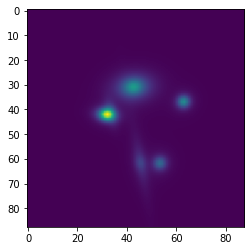

In [559]:
plt.imshow(image[2].reshape(88,88).numpy())

In [421]:
torch.tensor(images[:]).reshape(1, 1, slen, slen)

tensor([[[[0.0030, 0.0033, 0.0037,  ..., 0.3213, 0.3564, 0.3898],
          [0.0035, 0.0038, 0.0042,  ..., 0.4145, 0.4537, 0.4878],
          [0.0039, 0.0043, 0.0048,  ..., 0.5315, 0.5709, 0.6000],
          ...,
          [0.6000, 0.5709, 0.5315,  ..., 0.0048, 0.0043, 0.0039],
          [0.4878, 0.4537, 0.4145,  ..., 0.0042, 0.0038, 0.0035],
          [0.3898, 0.3564, 0.3213,  ..., 0.0037, 0.0033, 0.0030]]]])

In [381]:
dithers

(0, 0)